In [219]:
import sys
import pandas as pd
import numpy as np
import os
import operator
import string
import re
import random
import warnings
warnings.filterwarnings('ignore')
import platform
import json, pickle
from collections import defaultdict
from scipy import stats

import sklearn as sk
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor
from bayes_opt import BayesianOptimization

import optuna

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import AllChem, rdDepictor, MolFromSmiles, Descriptors, rdMolDescriptors, Crippen, QED, EState, Lipinski, MolSurf, Fragments

import deepchem as dc
from deepchem.feat.molecule_featurizers import MolGraphConvFeaturizer
from deepchem.feat import RDKitDescriptors

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
import catboost as cat
import lightgbm as lgb

In [220]:
CFG = {'SEED' : 1218,}

In [221]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    check_random_state(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [222]:
train_mlm = pd.read_csv('./Data/eda/mlm_or.csv')
train_hlm = pd.read_csv('./Data/eda/hlm_or.csv')
test_mlm = pd.read_csv('./Data/eda/mlm_or_test.csv')
test_hlm = pd.read_csv('./Data/eda/hlm_or_test.csv')

In [223]:
X_mlm = train_mlm.drop(['MLM'], axis=1)
y_mlm = train_mlm['MLM']
X_hlm = train_hlm.drop(['HLM'], axis=1)
y_hlm = train_hlm['HLM']

In [224]:
knn = KNeighborsRegressor(n_neighbors=10, n_jobs=-1)
bagging = BaggingRegressor(n_estimators=15, n_jobs=-1, random_state=CFG['SEED'])
ets = ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=CFG['SEED'])
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=CFG['SEED'])
xgb = xgb.XGBRegressor(n_estimators=200, n_jobs=-1, random_state=CFG['SEED'])
lgbm = lgb.LGBMRegressor(n_estimators=200, n_jobs=-1, random_state=CFG['SEED'])

In [225]:
scaler = StandardScaler()
train_mlm_scaled = scaler.fit_transform(X_mlm)
test_mlm_scaled = scaler.transform(test_mlm)

In [226]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=CFG['SEED'])
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

In [227]:
best_ml = [
    knn, bagging, ets, rf, xgb, lgbm
]

meta_ml_mlm_X_train=[]
meta_ml_mlm_X_test=[]

for estimator in best_ml:

    print(estimator)
    
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, train_mlm_scaled, y_mlm, test_mlm_scaled, 8)
    
    meta_ml_mlm_X_train.append(temp_X_train)
    meta_ml_mlm_X_test.append(temp_X_test)
    
meta_ml_mlm_X_train=np.hstack(meta_ml_mlm_X_train)
meta_ml_mlm_X_test=np.hstack(meta_ml_mlm_X_test)

meta_ml_mlm_X_train.shape, meta_ml_mlm_X_test.shape

KNeighborsRegressor(n_jobs=-1, n_neighbors=10)
BaggingRegressor(n_estimators=15, n_jobs=-1, random_state=1218)
ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=1218)
RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=1218)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=1218, ...)
LGBMRegresso

((3362, 6), (483, 6))

In [228]:
meta_clf_mlm = LinearRegression()
meta_clf_mlm.fit(meta_ml_mlm_X_train, y_mlm)
prediction_mlm = meta_clf_mlm.predict(meta_ml_mlm_X_test)
prediction_mlm.shape

(483,)

In [229]:
train_hlm_scaled = scaler.fit_transform(X_hlm)
test_hlm_scaled = scaler.transform(pd.concat([pd.DataFrame(prediction_mlm, columns=['MLM']), test_hlm], axis=1))

In [230]:
best_ml = [
    knn, bagging, ets, rf, xgb, lgbm
]

meta_ml_hlm_X_train=[]
meta_ml_hlm_X_test=[]

for estimator in best_ml:

    print(estimator)
    
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, train_hlm_scaled, y_hlm, test_hlm_scaled, 8)
    
    meta_ml_hlm_X_train.append(temp_X_train)
    meta_ml_hlm_X_test.append(temp_X_test)
    
meta_ml_hlm_X_train=np.hstack(meta_ml_hlm_X_train)
meta_ml_hlm_X_test=np.hstack(meta_ml_hlm_X_test)

meta_ml_hlm_X_train.shape, meta_ml_hlm_X_test.shape

KNeighborsRegressor(n_jobs=-1, n_neighbors=10)
BaggingRegressor(n_estimators=15, n_jobs=-1, random_state=1218)
ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=1218)
RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=1218)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=1218, ...)
LGBMRegresso

((3362, 6), (483, 6))

In [231]:
meta_clf_hlm = LinearRegression()
meta_clf_hlm.fit(meta_ml_hlm_X_train, y_hlm)
prediction_hlm = meta_clf_hlm.predict(meta_ml_hlm_X_test)
prediction_hlm.shape

(483,)

In [232]:
sample_submission = pd.read_csv('./Data/sample_submission.csv')
sample_submission['MLM'] = np.round(prediction_mlm, 3)
sample_submission['HLM'] = np.round(prediction_hlm, 3)
sample_submission.to_csv('./Data/result.csv', index=False)


In [233]:
sample_submission['MLM'] = prediction_mlm
sample_submission['HLM'] = prediction_hlm
sample_submission.to_csv('./Data/result.csv', index=False)

In [234]:
sample_submission

,id,MLM,HLM
0,TEST_000,29.325725,57.770552
1,TEST_001,67.208356,81.031443
2,TEST_002,36.399509,59.634122
3,TEST_003,52.101722,69.836868
4,TEST_004,67.988618,82.635555
...,...,...,...
478,TEST_478,14.901342,49.332141
479,TEST_479,80.063076,87.179043
480,TEST_480,46.369111,67.172909
481,TEST_481,53.843394,72.943959


In [235]:
result = (sample_submission.iloc[:, 1:] + pd.read_csv('./Data/graph.csv').iloc[:, 1:])/2
pd.concat([sample_submission.iloc[:, :1], result], axis=1).to_csv('./Data/result.csv', index=False)

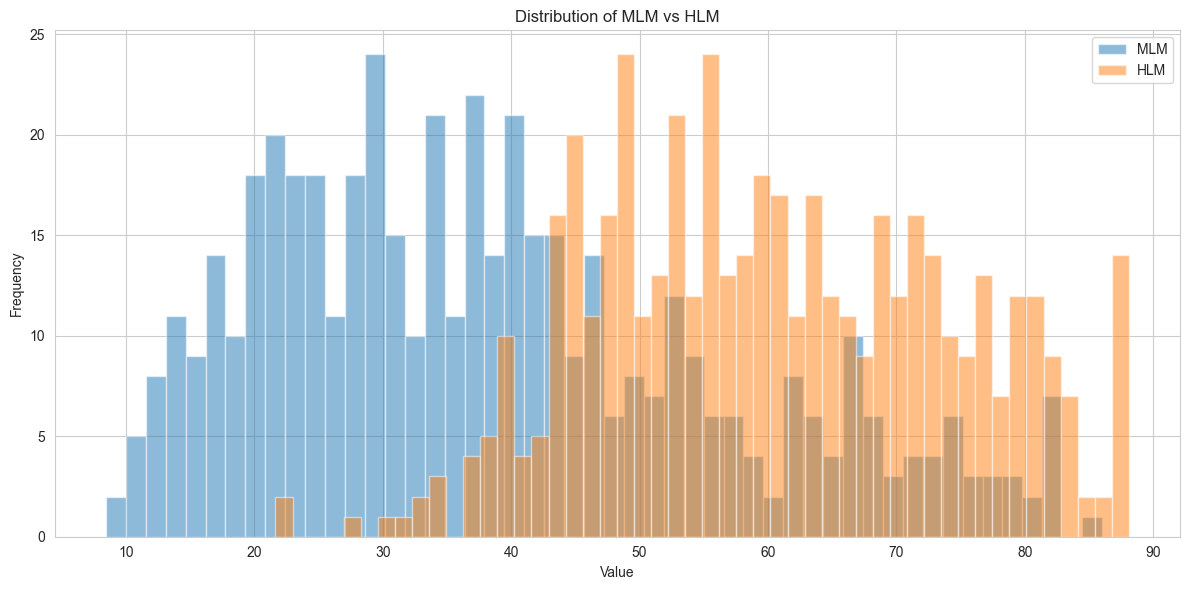

,MLM,HLM
count,483.000000,483.000000
mean,38.585461,60.463062
std,17.763553,13.711139
min,8.456172,21.656119
25%,24.573051,49.315672
50%,36.049569,59.634122
75%,49.518208,71.418204
max,86.001218,88.088395


In [236]:
# 타겟 예측값 살펴보기
desc_stats = sample_submission[['MLM', 'HLM']].describe()

# Plot histograms for MLM and HLM
plt.figure(figsize=(12, 6))

plt.hist(sample_submission['MLM'], bins=50, alpha=0.5, label='MLM')
plt.hist(sample_submission['HLM'], bins=50, alpha=0.5, label='HLM')

plt.title('Distribution of MLM vs HLM')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

desc_stats